# Demand Forecasting Model Documentation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
# read the data
drive.mount('/content/drive/')
path = "/content/drive/dataset"

# Small Training dataset (1000 data points)
df = pd.read_csv(f"{path}data.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## EDA

In [ ]:
df.head()

,Unnamed: 0,SKU,date,Sales
0,105375,L2011TPD-1,01-01-2019,1
1,105374,LA2191 -1,01-01-2019,1
2,105373,JP7052 -2,01-01-2019,1
3,105372,VA-35,01-01-2019,1
4,105371,be1903 -2,01-01-2019,1


In [ ]:
df.shape

(105376, 3)

In [ ]:
df.columns = ['ID','SKU','Date','Sales']
df.drop('ID', axis = 1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.head()

,SKU,Date,Sales
0,L2011TPD-1,2019-01-01,1
1,LA2191 -1,2019-01-01,1
2,JP7052 -2,2019-01-01,1
3,VA-35,2019-01-01,1
4,be1903 -2,2019-01-01,1


In [ ]:
df.nunique()

SKU      10016
Date      1415
Sales        7
dtype: int64

In [ ]:
# Resampling to monthly frequency per SKU
df_monthly = df.groupby('SKU').resample('M', on='Date').sum().reset_index()

# Top 5 SKUs by total sales
top_sku = df_monthly.groupby('SKU')['Sales'].sum().nlargest(5).index

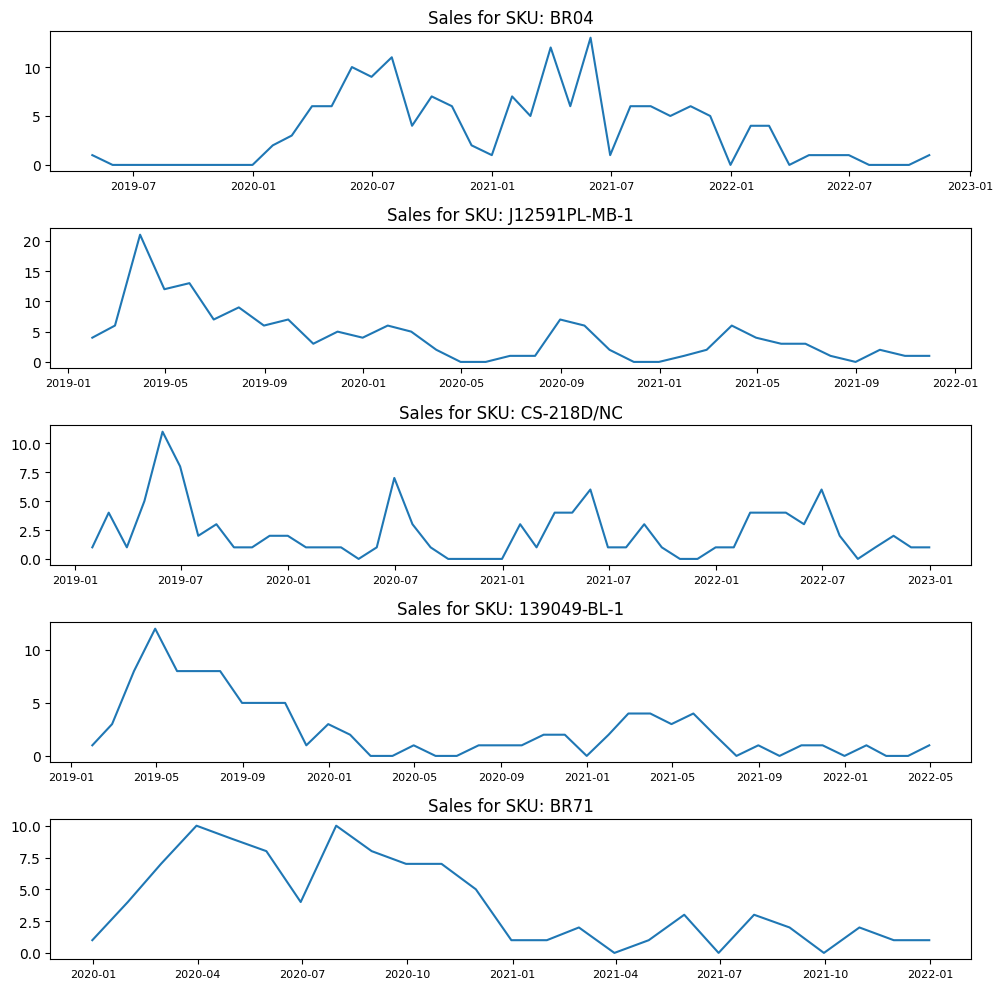

In [ ]:
# Plotting
fig, ax = plt.subplots(len(top_sku), 1, figsize=(10, 10))

for i, sku in enumerate(top_sku):
    df_sku = df_monthly[df_monthly['SKU'] == sku]
    ax[i].plot(df_sku['Date'], df_sku['Sales'])
    ax[i].set_title(f'Sales for SKU: {sku}')

plt.tight_layout()
plt.show()

In [ ]:
###Latest update

df_new = df_monthly[df_monthly['SKU'].isin(top_sku)]
df_new

,SKU,Date,Sales
3454,139049-BL-1,2019-01-31,1
3455,139049-BL-1,2019-02-28,3
3456,139049-BL-1,2019-03-31,8
3457,139049-BL-1,2019-04-30,12
3458,139049-BL-1,2019-05-31,8
...,...,...,...
89005,J12591PL-MB-1,2021-07-31,1
89006,J12591PL-MB-1,2021-08-31,0
89007,J12591PL-MB-1,2021-09-30,2
89008,J12591PL-MB-1,2021-10-31,1


Plots for: BR04


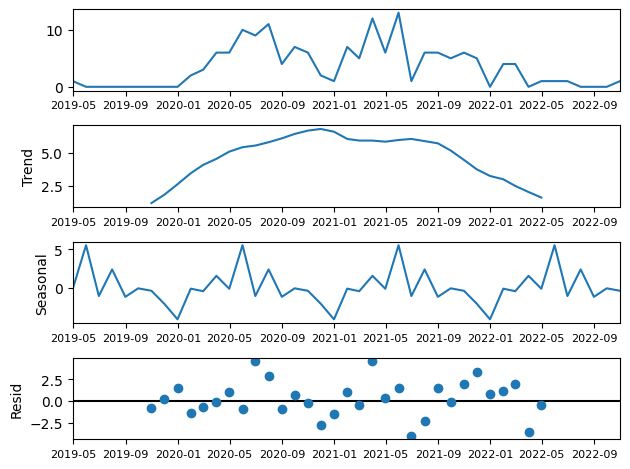



Plots for: J12591PL-MB-1


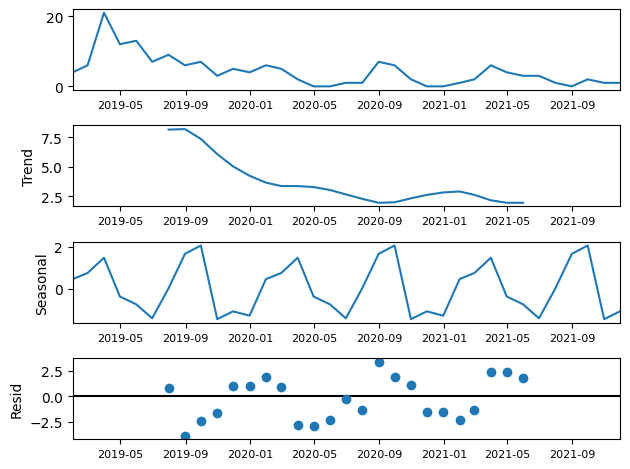



Plots for: CS-218D/NC


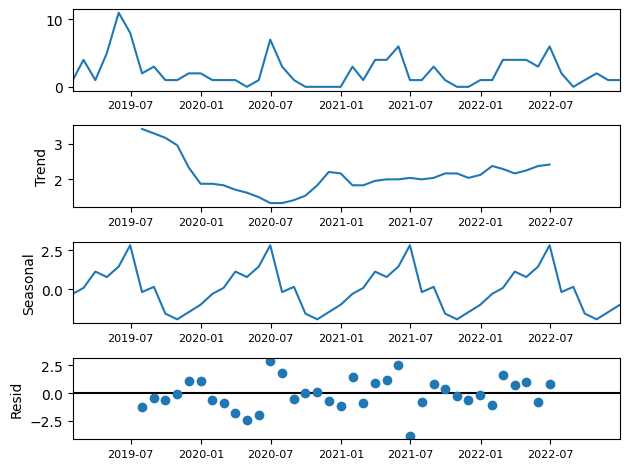



Plots for: 139049-BL-1


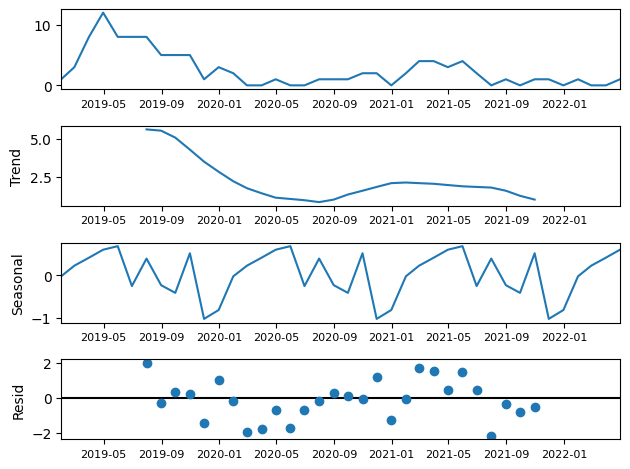



Plots for: BR71


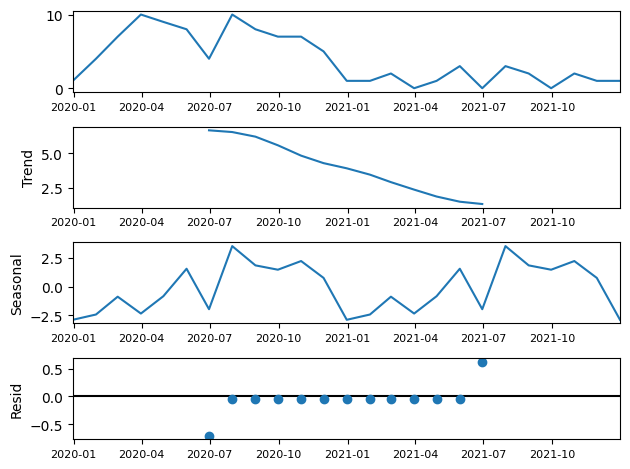

In [ ]:
###Latest update
import statsmodels.api as sm

plt.rcParams['xtick.labelsize'] = 8

for i, sku in enumerate(top_sku):
  df_temp = df_new[df_new['SKU'] == sku][['Sales','Date']].set_index('Date')
  print("Plots for:", sku)
  decomposition = sm.tsa.seasonal_decompose(df_temp, model='additive')
  fig = decomposition.plot()
  plt.show()

  # Add a break after each set of plots
  if i != len(top_sku) - 1:
      print('\n' + '='*40 + '\n')  # Print a line break

Based on the plots, it looks like SKUs -139049-BL-1, CS-218D/NC and BR04 have seasonal components.
Additionally, BR 71 seems to follow a trend. We will perform dickey fuller test to confirm the stationarity of the above SKUs to get confirmation

> Indented block



ACF Plot for BR04 after 1 diff


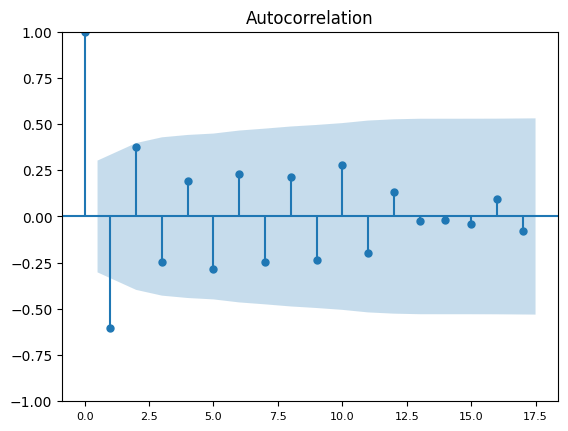

PACF Plot for BR04 after 1 diff


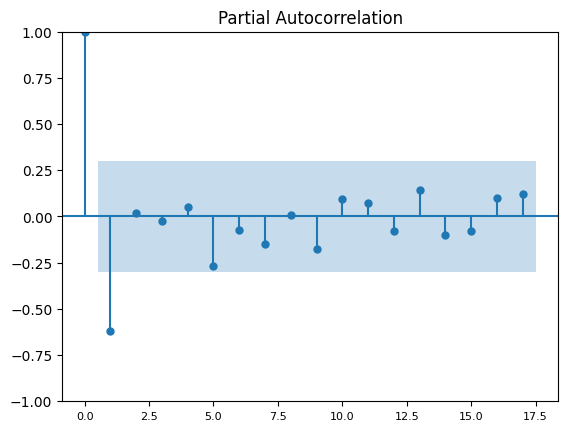



ACF Plot for J12591PL-MB-1 after 1 diff


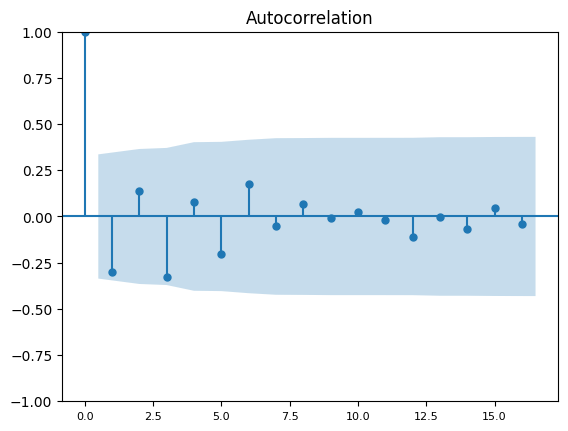

PACF Plot for J12591PL-MB-1 after 1 diff


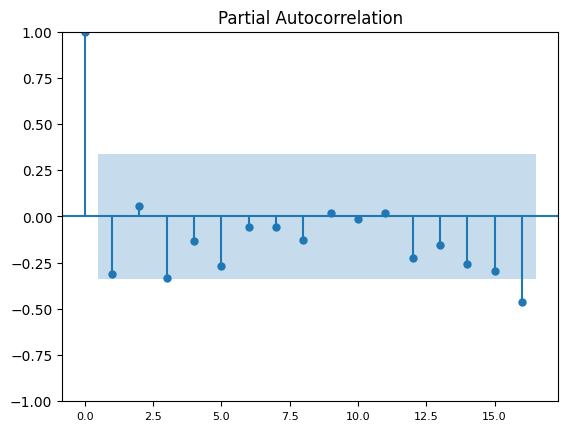



ACF Plot for CS-218D/NC after 1 diff


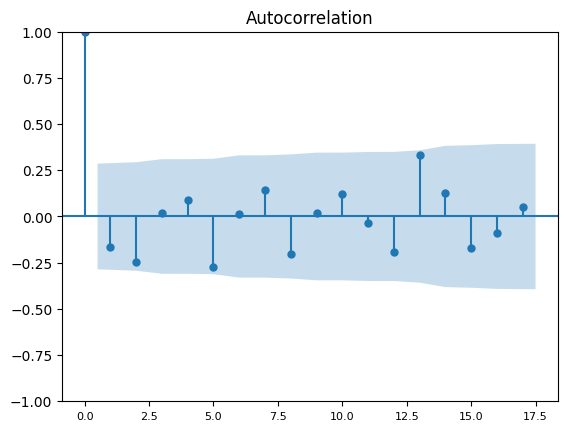

PACF Plot for CS-218D/NC after 1 diff


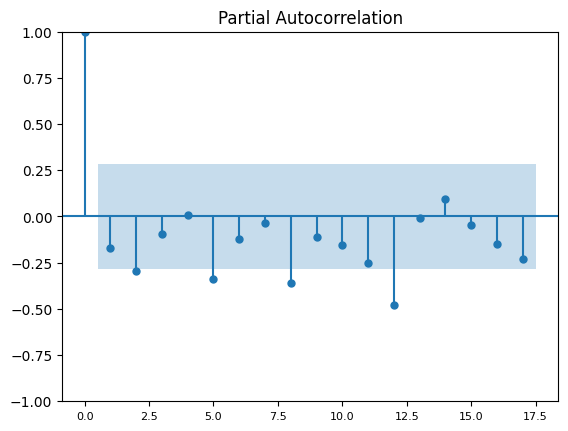



ACF Plot for 139049-BL-1 after 1 diff


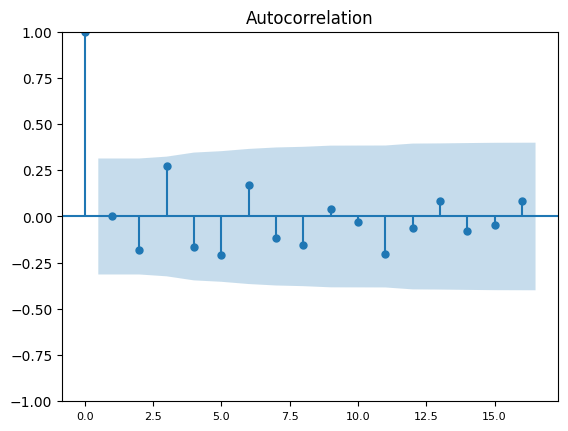

PACF Plot for 139049-BL-1 after 1 diff


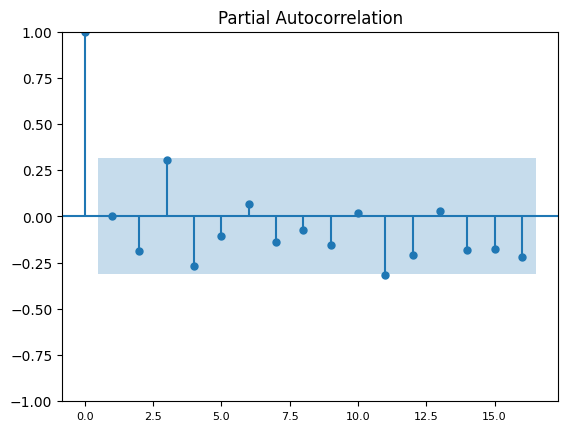



ACF Plot for BR71 after 1 diff


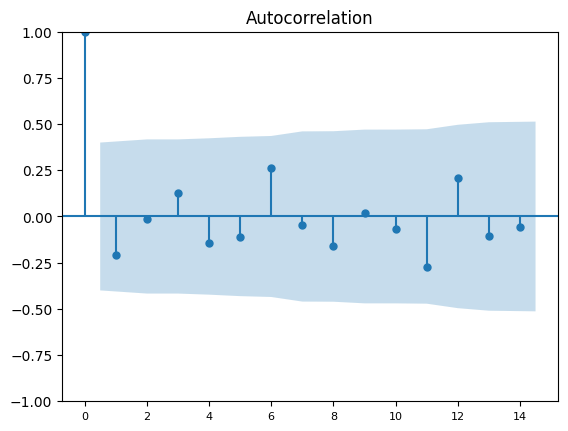

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

for i, sku in enumerate(top_sku):
  df_temp = df_new[df_new['SKU'] == sku][['Sales','Date']].set_index('Date')
  df_temp_one = (df_temp-df_temp.shift(1)).dropna()
  # df_temp_two = (df_temp_one-df_temp_one.shift(1)).dropna()

  print("ACF Plot for {} after 1 diff".format(sku))
  plot_acf(df_temp_one.dropna())
  plt.show()
  if sku != 'BR71':
    print("PACF Plot for {} after 1 diff".format(sku))
    plot_pacf(df_temp_one.dropna())
    plt.show()

  # Add a break after each set of plots
  if i != len(top_sku) - 1:
      print('\n' + '='*40 + '\n')  # Print a line break

# 1. Statistic test for stationarity

> **Get data of top N(5) SKUs**

In [ ]:
df.head()

,SKU,Date,Sales
0,L2011TPD-1,2019-01-01,1
1,LA2191 -1,2019-01-01,1
2,JP7052 -2,2019-01-01,1
3,VA-35,2019-01-01,1
4,be1903 -2,2019-01-01,1


In [ ]:
### Function to get top n SKUs from df
import pandas as pd

def get_top_skus(df, n, freq='D'):
    # Ensure 'Date' column is of datetime type
    df['Date'] = pd.to_datetime(df['Date'])

    # Set 'Date' column as index, required for resampling
    df = df.set_index('Date')

    # Resample sales data as per the specified frequency and SKU
    if freq == 'M':
        df = df.groupby('SKU').resample('M').sum()

    # Reset index
    df = df.reset_index()

    # Calculate total sales for each SKU
    total_sales = df.groupby('SKU')['Sales'].sum().reset_index()

    # Get top n SKUs with the most sales
    top_skus = total_sales.nlargest(n, 'Sales')['SKU']

    # Create a new DataFrame with only top n SKUs
    df_top_skus = df[df['SKU'].isin(top_skus)]

    return df_top_skus

In [ ]:
### Use the function to get top 5 SKUs from data
df_top_skus = get_top_skus(df, 5, 'M')

In [ ]:
df_top_skus.head()

,SKU,Date,Sales
3454,139049-BL-1,2019-01-31,1
3455,139049-BL-1,2019-02-28,3
3456,139049-BL-1,2019-03-31,8
3457,139049-BL-1,2019-04-30,12
3458,139049-BL-1,2019-05-31,8


In [ ]:
df_fin = df_top_skus.copy()
df_fin.head()

,SKU,Date,Sales
3454,139049-BL-1,2019-01-31,1
3455,139049-BL-1,2019-02-28,3
3456,139049-BL-1,2019-03-31,8
3457,139049-BL-1,2019-04-30,12
3458,139049-BL-1,2019-05-31,8


> **Perform ADF test to each SKU and apply first order differencing to non-stationary SKU**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationary_test_and_transformation(df):
    # Prepare data by SKU
    grouped = df.groupby('SKU')

    # Initialize list to store SKUs that need differencing
    skus_to_difference = []

    # Perform ADF test on each SKU
    for sku, group in grouped:
        result = adfuller(group['Sales'])
        print(f'\nBefore Transformation:')
        print(f'SKU: {sku}')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

        # If p-value is greater than 0.05, add SKU to list
        if result[1] > 0.05:
            skus_to_difference.append(sku)

    # Apply first order differencing to non-stationary SKUs and drop the NaN values
    for sku in skus_to_difference:
        df.loc[df['SKU'] == sku, 'Sales'] = df[df['SKU'] == sku]['Sales'].diff()

        # Drop NaN values from the SKU data
        df = df.dropna()

        # Perform ADF test again on the transformed SKU data
        result = adfuller(df.loc[df['SKU'] == sku, 'Sales'])
        print(f'\nAfter Transformation:')
        print(f'SKU: {sku}')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

    print("\nHead of transformed dataset:")
    print(df.head())

    return df


For SKUs 'BR71', 'CS-218D/NC'and 'J12591PL-MB-1', the p-values are significantly less than 0.05, indicating strong evidence against the null hypothesis, hence we reject the null hypothesis and conclude that these series are stationary.

However, for SKU '139049-BL-1', 'BR04', the p-value is greater than 0.05, which means we cannot reject the null hypothesis that the time series has a unit root and is non-stationary.

To handle the non-stationarity for the  '139049-BL-1', 'BR04' SKU, we can apply first order differencing to the sales data. This operation substitutes each sales value with the difference between it and the previous one.

In [ ]:
df_adf_transform = stationary_test_and_transformation(df_top_skus)
## here the result will show the ADF test results for all SKUs


Before Transformation:
SKU: 139049-BL-1
ADF Statistic: -2.015068
p-value: 0.280006

Before Transformation:
SKU: BR04
ADF Statistic: -1.772710
p-value: 0.394092

Before Transformation:
SKU: BR71
ADF Statistic: -2.892532
p-value: 0.046223

Before Transformation:
SKU: CS-218D/NC
ADF Statistic: -4.032401
p-value: 0.001250

Before Transformation:
SKU: J12591PL-MB-1
ADF Statistic: -3.210772
p-value: 0.019370

After Transformation:
SKU: 139049-BL-1
ADF Statistic: -5.911962
p-value: 0.000000

After Transformation:
SKU: BR04
ADF Statistic: -12.557982
p-value: 0.000000

Head of transformed dataset:
              SKU       Date  Sales
3455  139049-BL-1 2019-02-28    2.0
3456  139049-BL-1 2019-03-31    5.0
3457  139049-BL-1 2019-04-30    4.0
3458  139049-BL-1 2019-05-31   -4.0
3459  139049-BL-1 2019-06-30    0.0


# 2. ARIMA model to forecast sales
- Train: First 24 months,
- Test: Next 12 months

> 1. ARIMA Model

In [ ]:
df_adf_transform

,SKU,Date,Sales
3455,139049-BL-1,2019-02-28,2.0
3456,139049-BL-1,2019-03-31,5.0
3457,139049-BL-1,2019-04-30,4.0
3458,139049-BL-1,2019-05-31,-4.0
3459,139049-BL-1,2019-06-30,0.0
...,...,...,...
89005,J12591PL-MB-1,2021-07-31,1.0
89006,J12591PL-MB-1,2021-08-31,0.0
89007,J12591PL-MB-1,2021-09-30,2.0
89008,J12591PL-MB-1,2021-10-31,1.0


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


>**Function to find best ARIMA models for each SKU and measure the performance of each model**

In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

def find_best_model_and_forecast(sku, train_start_date, train_end_date, test_end_date):
    # Get the sales data for the given SKU
    sku_data = df_adf_transform[df_adf_transform['SKU'] == sku].sort_values('Date')

    # Split the data into training and test sets (first 24 months for training, next 12 for testing)
    train_data = sku_data[(sku_data['Date'] >= train_start_date) & (sku_data['Date'] < train_end_date)]['Sales']
    test_data = sku_data[(sku_data['Date'] >= train_end_date) & (sku_data['Date'] < test_end_date)]['Sales']

    # Use auto_arima to find the best ARIMA parameters and fit on training data
    model = auto_arima(train_data, error_action='ignore', suppress_warnings=True)
    model.fit(train_data)

    # Print the ARIMA order for the selected model
    print(f"Best ARIMA order for SKU {sku}: {model.order}")

    # Make predictions for the next 12 months
    predictions = model.predict(n_periods=len(test_data))

    # Calculate error metrics
    mse = mean_squared_error(test_data, predictions)
    mae = mean_absolute_error(test_data, predictions)
    print(f"Mean Squared Error for SKU {sku}: {mse}")
    print(f"Mean Absolute Error for SKU {sku}: {mae}")

    # Return the best model, predictions and error metrics
    return model, predictions, mse, mae

In [ ]:
model, predictions, mse, mae = find_best_model_and_forecast(sku='139049-BL-1',
                                                            train_start_date='2019-01-01',
                                                            train_end_date='2021-01-01',
                                                            test_end_date='2022-01-01')

Best ARIMA order for SKU 139049-BL-1: (0, 0, 0)
Mean Squared Error for SKU 139049-BL-1: 1.8333333333333333
Mean Absolute Error for SKU 139049-BL-1: 1.1666666666666667


In [ ]:
model, predictions, mse, mae = find_best_model_and_forecast(sku='BR04',
                                                            train_start_date='2019-01-01',
                                                            train_end_date='2021-01-01',
                                                            test_end_date='2022-01-01')

Best ARIMA order for SKU BR04: (0, 0, 0)
Mean Squared Error for SKU BR04: 30.916666666666668
Mean Absolute Error for SKU BR04: 4.416666666666667


In [ ]:
model, predictions, mse, mae = find_best_model_and_forecast(sku='BR71',
                                                            train_start_date='2019-01-01',
                                                            train_end_date='2021-01-01',
                                                            test_end_date='2022-01-01')

Best ARIMA order for SKU BR71: (1, 0, 0)
Mean Squared Error for SKU BR71: 15.756382362152584
Mean Absolute Error for SKU BR71: 3.7908196183952843


In [ ]:
model, predictions, mse, mae = find_best_model_and_forecast(sku='CS-218D/NC',
                                                            train_start_date='2019-01-01',
                                                            train_end_date='2021-01-01',
                                                            test_end_date='2022-01-01')

Best ARIMA order for SKU CS-218D/NC: (0, 0, 1)
Mean Squared Error for SKU CS-218D/NC: 3.400764296889596
Mean Absolute Error for SKU CS-218D/NC: 1.6823270943024855


In [ ]:
model, predictions, mse, mae = find_best_model_and_forecast(sku='J12591PL-MB-1',
                                                            train_start_date='2019-01-01',
                                                            train_end_date='2021-01-01',
                                                            test_end_date='2022-01-01')

Best ARIMA order for SKU J12591PL-MB-1: (0, 1, 0)
Mean Squared Error for SKU J12591PL-MB-1: 7.454545454545454
Mean Absolute Error for SKU J12591PL-MB-1: 2.1818181818181817


> **Visualize the forecasting trend of sales of SKUs (take 139049-BL-1 as example)**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
def plot_forecast_predictions(sku,train_start_date, train_end_date, test_end_date,p,d,q):

    # Get the sales data for the given SKU
    sku_data = df_adf_transform[df_adf_transform['SKU'] == sku].sort_values('Date')

    # Split the data into training and test sets (first 24 months for training, next 12 for testing)
    train_data = sku_data[(sku_data['Date'] >= train_start_date) & (sku_data['Date'] < train_end_date)].set_index('Date')['Sales']
    test_data = sku_data[(sku_data['Date'] >= train_end_date) & (sku_data['Date'] < test_end_date)].set_index('Date')['Sales']



    # print(train_data.head())
    pred_start_date=test_data.index[0]
    pred_end_date=test_data.index[-1]

    # Use auto_arima to find the best ARIMA parameters and fit on training data
    model=ARIMA(train_data, order=(p,d,q)).fit()
    # model.summary()
    # pred = model.predict(n_periods=len(test_data))

    pred= model.predict(start=pred_start_date,end=pred_end_date)

    train_data.plot(legend=True, label='Train', figsize=(10,6))
    test_data.plot(legend=True, label= 'Test')
    pred.plot(legend=True, label='ARIMA prediction')


    mse = mean_squared_error(test_data, pred)
    mae = mean_absolute_error(test_data, pred)
    print(f"Mean Squared Error for SKU {sku}: {mse}")
    print(f"Mean Absolute Error for SKU {sku}: {mae}")

    return mse

In [ ]:
import pandas as pd

# Define column names
columns = ['SKU', 'ARIMA MSE', 'SARIMA MSE']

# Create an empty DataFrame
output_models = pd.DataFrame(columns=columns)

# Print the empty DataFrame
print(output_models)


Empty DataFrame
Columns: [SKU, ARIMA MSE, SARIMA MSE]
Index: []


Mean Squared Error for SKU 139049-BL-1: 1.8352241130917504
Mean Absolute Error for SKU 139049-BL-1: 1.1739138495645944


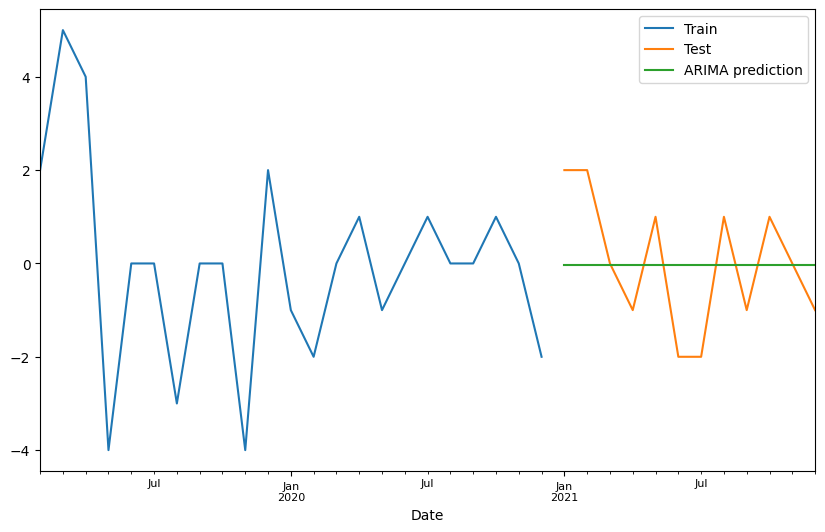

In [ ]:
#Plotting the predictions for SKU: 139049-BL-1
mse_1 = plot_forecast_predictions('139049-BL-1',  '2019-01-01', '2021-01-01', '2022-01-01',0,0,0)

output_models = output_models.append({'SKU': '139049-BL-1', 'ARIMA MSE': mse_1}, ignore_index=True)

In [ ]:
output_models

,SKU,ARIMA MSE,SARIMA MSE
0,139049-BL-1,1.835224,NaN


Mean Squared Error for SKU BR04: 30.916665862241462
Mean Absolute Error for SKU BR04: 4.416666666666667


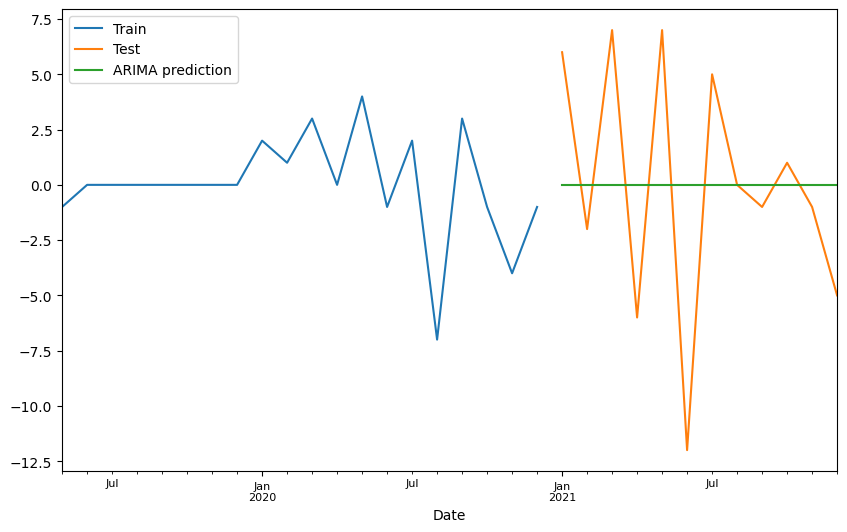

In [ ]:
#Plotting the predictions for SKU: 'BR04'
mse_2 = plot_forecast_predictions('BR04',  '2019-01-01', '2021-01-01', '2022-01-01',0,0,0)
output_models = output_models.append({'SKU': 'BR04', 'ARIMA MSE': mse_2}, ignore_index=True)

Mean Squared Error for SKU BR71: 15.757447772440438
Mean Absolute Error for SKU BR71: 3.7909657397375436


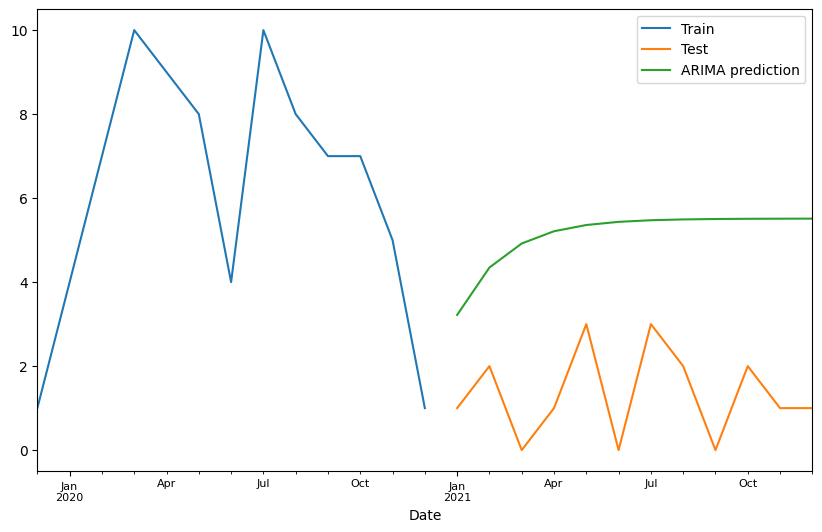

In [ ]:
#Plotting the predictions for SKU: 'BR71'
mse_3 = plot_forecast_predictions('BR71',  '2019-01-01', '2021-01-01', '2022-01-01',1,0,0)
output_models = output_models.append({'SKU': 'BR71', 'ARIMA MSE': mse_3}, ignore_index=True)

Mean Squared Error for SKU CS-218D/NC: 3.4007647459954016
Mean Absolute Error for SKU CS-218D/NC: 1.682327514487706


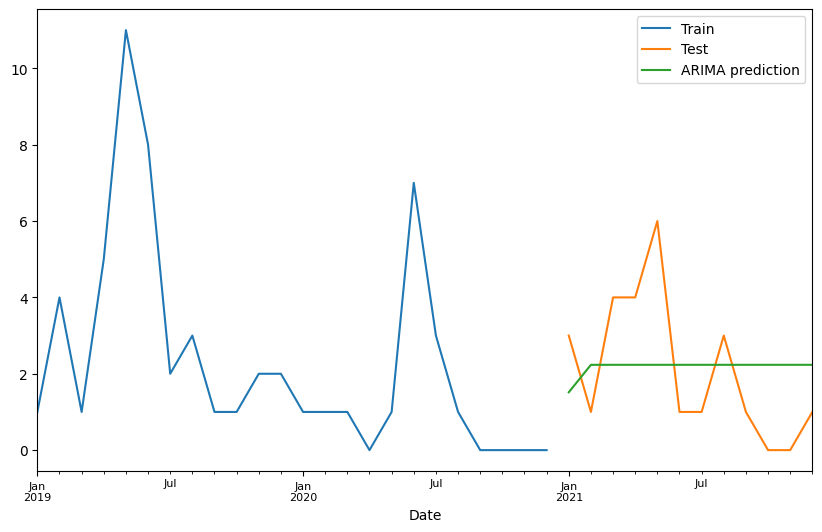

In [ ]:
#Plotting the predictions for SKU: 'CS-218D/NC'
mse_4 = plot_forecast_predictions('CS-218D/NC',  '2019-01-01', '2021-01-01', '2022-01-01',0,0,1)
output_models = output_models.append({'SKU': 'CS-218D/NC', 'ARIMA MSE': mse_4}, ignore_index=True)

Mean Squared Error for SKU J12591PL-MB-1: 7.454545454545454
Mean Absolute Error for SKU J12591PL-MB-1: 2.1818181818181817


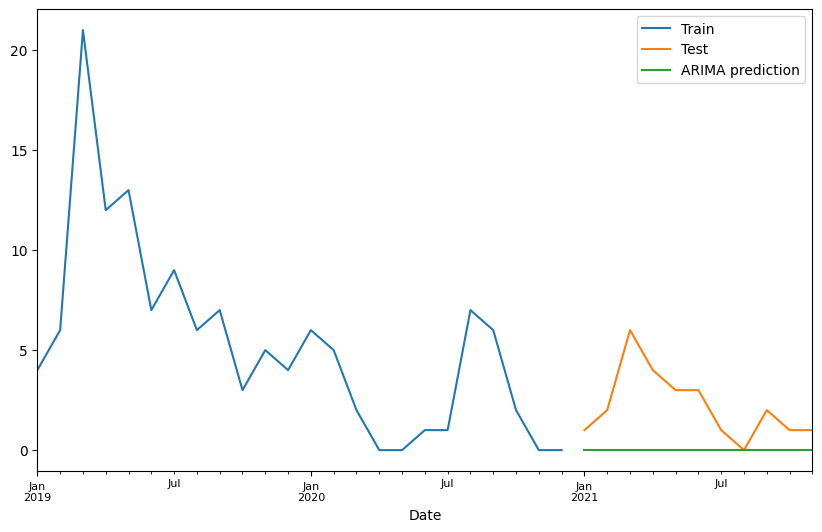

In [ ]:
#Plotting the predictions for SKU: 'J12591PL-MB-1'
mse_5 = plot_forecast_predictions('J12591PL-MB-1',  '2019-01-01', '2021-01-01', '2022-01-01',0,1,0)
output_models = output_models.append({'SKU': 'J12591PL-MB-1', 'ARIMA MSE': mse_5}, ignore_index=True)

In [ ]:
# As you can see none of the plots are able to capture the seasonal element of the data and as a result ARIMA is not successful

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def plot_sarima_forecast_predictions(sku,train_start_date, train_end_date, test_end_date,p,d,q,s_p):

    # Get the sales data for the given SKU
    sku_data = df_adf_transform[df_adf_transform['SKU'] == sku].sort_values('Date')

    # Split the data into training and test sets (first 24 months for training, next 12 for testing)
    train_data = sku_data[(sku_data['Date'] >= train_start_date) & (sku_data['Date'] < train_end_date)].set_index('Date')['Sales']
    test_data = sku_data[(sku_data['Date'] >= train_end_date) & (sku_data['Date'] < test_end_date)].set_index('Date')['Sales']

    # print(train_data.head())
    pred_start_date=test_data.index[0]
    pred_end_date=test_data.index[-1]

    # Use auto_arima to find the best ARIMA parameters and fit on training data

    # Fit the model
    model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(0,1,0, s_p))
    model_fit = model.fit()

    pred= model_fit.predict(start=pred_start_date,end=pred_end_date)
    train_data.plot(legend=True, label='Train', figsize=(10,6))
    test_data.plot(legend=True, label= 'Test')
    pred.plot(legend=True, label='SARIMAX prediction')



    mse = mean_squared_error(test_data, pred)
    mae = mean_absolute_error(test_data, pred)

    print(f"Mean Squared Error for SKU {sku}: {mse}")
    print(f"Mean Absolute Error for SKU {sku}: {mae}")

    return mse

Mean Squared Error for SKU 139049-BL-1: 4.083333333333333
Mean Absolute Error for SKU 139049-BL-1: 1.5833333333333333


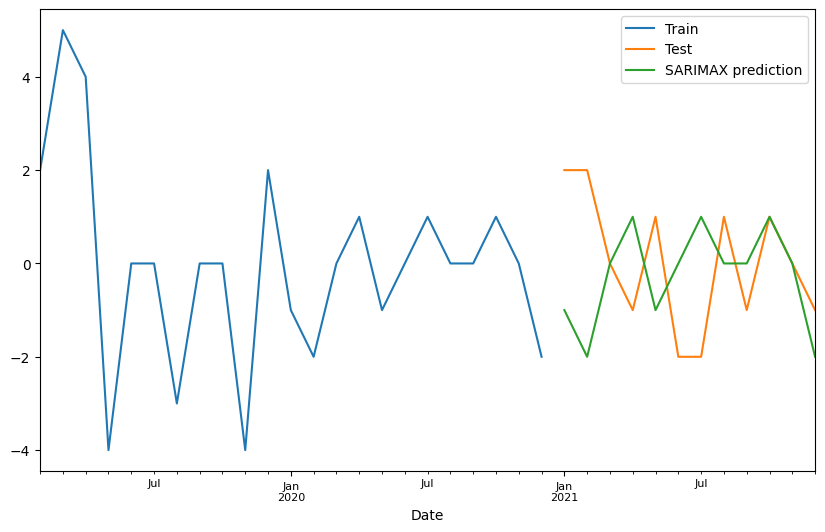

In [ ]:
s_mse_1 = plot_sarima_forecast_predictions('139049-BL-1',  '2019-01-01', '2021-01-01', '2022-01-01',0,0,0,12)
output_models.loc[output_models['SKU'] == '139049-BL-1', 'SARIMA MSE'] = s_mse_1

Mean Squared Error for SKU BR04: 25.833333333333332
Mean Absolute Error for SKU BR04: 4.5


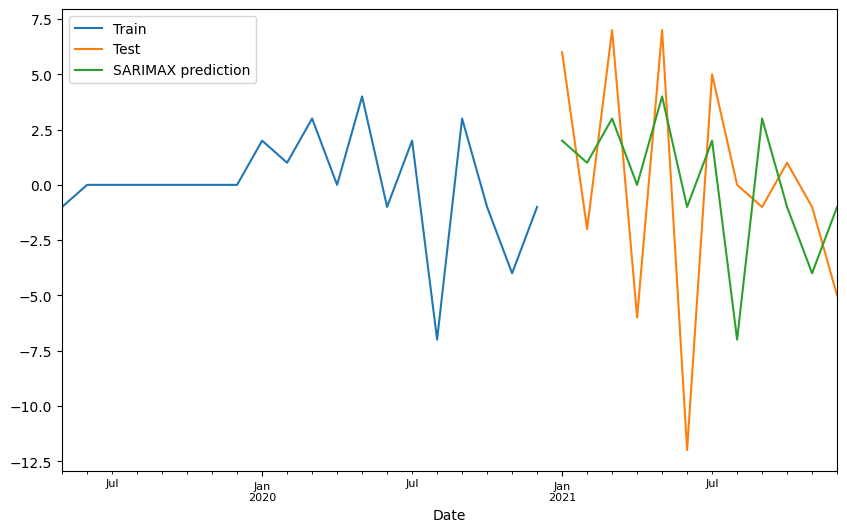

In [ ]:
s_mse_2 = plot_sarima_forecast_predictions('BR04',  '2019-01-01', '2021-01-01', '2022-01-01',0,0,0,12)
output_models.loc[output_models['SKU'] == 'BR04', 'SARIMA MSE'] = s_mse_2

Mean Squared Error for SKU BR71: 23.001286686922878
Mean Absolute Error for SKU BR71: 4.2863951710039


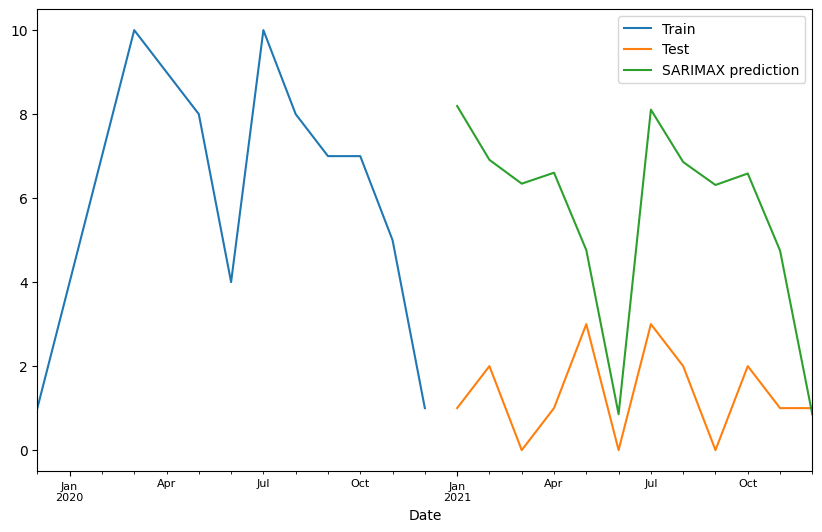

In [ ]:
s_mse_3 = plot_sarima_forecast_predictions('BR71',  '2019-01-01', '2021-01-01', '2022-01-01',1,0,0,6)
output_models.loc[output_models['SKU'] == 'BR71', 'SARIMA MSE'] = s_mse_3

Mean Squared Error for SKU CS-218D/NC: 8.570024774079245
Mean Absolute Error for SKU CS-218D/NC: 2.217949683428547


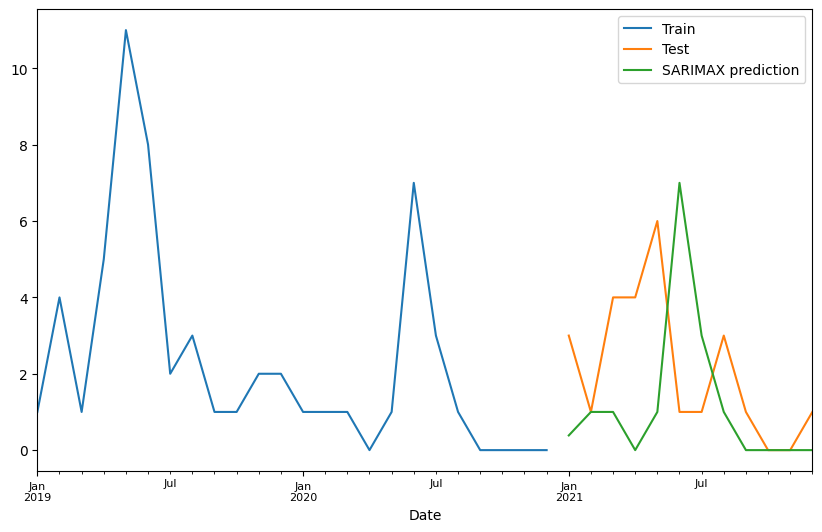

In [ ]:
s_mse_4 = plot_sarima_forecast_predictions('CS-218D/NC',  '2019-01-01', '2021-01-01', '2022-01-01',0,0,1,12)
output_models.loc[output_models['SKU'] == 'CS-218D/NC', 'SARIMA MSE'] = s_mse_4

Mean Squared Error for SKU J12591PL-MB-1: 24.90909090909914
Mean Absolute Error for SKU J12591PL-MB-1: 4.181818181818972


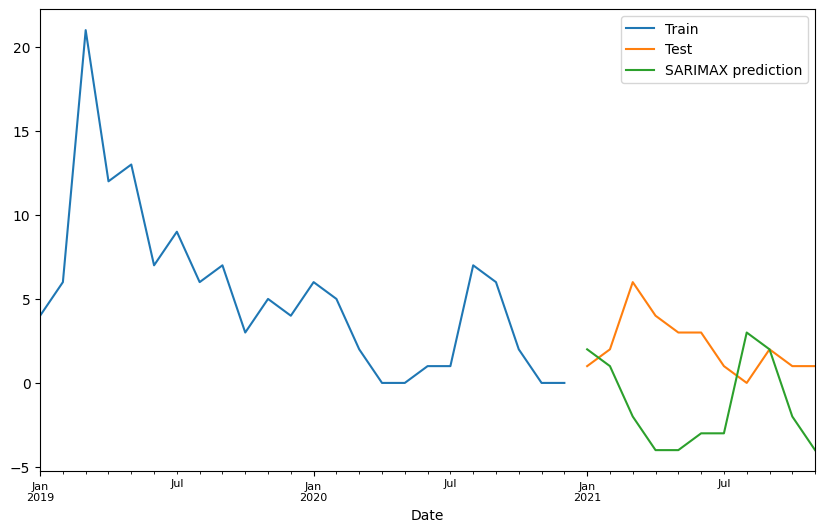

In [ ]:
s_mse_5 = plot_sarima_forecast_predictions('J12591PL-MB-1',  '2019-01-01', '2021-01-01', '2022-01-01',0,1,0,12)
output_models.loc[output_models['SKU'] == 'J12591PL-MB-1', 'SARIMA MSE'] = s_mse_5

In [ ]:
output_models

,SKU,ARIMA MSE,SARIMA MSE
0,139049-BL-1,1.835224,4.083333
1,BR04,30.916666,25.833333
2,BR71,15.757448,23.001287
3,CS-218D/NC,3.400765,8.570025
4,J12591PL-MB-1,7.454545,24.909091


## Inventory Management Strategy

The function will take as inputs the forecasted sales and your lead time, average demand, demand volatility, and lead time volatility.

We will use the following formula to calculate safety stock:

> $Safety Stock = Z * sqrt((Average Demand)^2 * (Lead Time Volatility)^2 + (Demand Volatility)^2 * (Lead Time)^2)$

This formula assumes that
- demand and lead time are normally distributed
- Z is the number of standard deviations corresponding to the desired service level (the probability of not hitting a stockout during the lead time).
- 95% service level, which corresponds to Z = 1.645 for a normal distribution.

In [ ]:
import numpy as np

def calculate_inventory_parameters(sales_forecast, lead_time, avg_demand, demand_volatility, lead_time_volatility, service_level=0.95):
    # Standard normal value for the given service level
    Z = norm.ppf(service_level)

    # Calculate Safety Stock
    safety_stock = Z * np.sqrt((avg_demand**2 * lead_time_volatility**2)
                               + (demand_volatility**2 * lead_time**2))

    # Calculate Lead Time Demand
    lead_time_demand = avg_demand * lead_time

    # Calculate Reorder Point
    reorder_point = lead_time_demand + safety_stock

    # Create a DataFrame to store the results
    inventory_df = pd.DataFrame({
        'Forecasted Sales': sales_forecast,
        'Safety Stock': np.full(len(sales_forecast), safety_stock),
        'Lead Time Demand': np.full(len(sales_forecast), lead_time_demand),
        'Reorder Point': np.full(len(sales_forecast), reorder_point)
    })

    return inventory_df